# Demo of Fix Them Bones

In [1]:
%matplotlib widget

In [8]:
import numpy as np
import igl
import rainbow.math.vector3 as V3
import rainbow.math.quaternion as Q

import rainbow.geometry.surface_mesh as MESH
import rainbow.simulators.prox_rigid_bodies.api as API
import rainbow.simulators.prox_rigid_bodies.solver as SOLVER
import rainbow.simulators.prox_rigid_bodies.collision_detection as CD
import rainbow.simulators.prox_rigid_bodies.gauss_seidel as GS
import rainbow.util.viewer as VIEWER
from rainbow.util.timer import Timer

In [9]:
def fix_them_bones(engine, separation_distance=1.0, debug_on=True):
    
    timer = Timer('Stepper')
    timer.start()
    stats = {}
    
    x = SOLVER.get_position_vector(engine)    
    W = SOLVER.compute_inverse_mass_matrix(x, engine)
    
    stats = CD.run_collision_detection(engine, stats, debug_on)

    K = len(engine.contact_points)
    if K > 0:
        J = SOLVER.compute_jacobian_matrix(engine)
        WJT = W.dot(J.T)
        # This is the g-function, telling the solver how-much to push bones apart
        # at the contact
        g = np.zeros(4 * K, dtype=np.float64)
        # mu is supposed to be a vector of friction coefficients, and it is not really
        # used in this solver. It is a left-over because the GS solver was made for
        # friction problems.
        mu = np.zeros(4 * K, dtype=np.float64)        
        for k in range(K):
            cp = engine.contact_points[k]
            g[4 * k + 0] = cp.g - separation_distance
        sol, stats = GS.solve(J, WJT, g, mu, GS.prox_origin, engine, stats, debug_on, "")
        SOLVER.position_update(x, WJT.dot(sol), 1, engine)
        SOLVER.set_position_vector(x, engine)

    if debug_on:
        timer.end()
        stats['fix_them_bones'] = timer.elapsed
        stats['contact_points'] = len(engine.contact_points)
        stats['positions'] = x
        stats['body_names'] = list(engine.bodies)
        stats['max_gap'] = SOLVER.get_largest_gap_error(engine)

    return stats

In [10]:
engine = API.Engine()

# The envelope controls how close objects need to be before we generate
# a contact point between them. This setting should be larger than the
# separation we want to have between the bones, otherwise we might miss
# contact areas that need to be pushed apart.
engine.params.envelope = 0.3
print('engine.params.envelope = ',engine.params.envelope)

# If signed distance grid solution is too low then the interpolation
# errors might be larger than the separation/envelope distances we are
# solving for. If grid resolution is too high then it may take a long time
# to pre-compute the signed distance field. It is a bit of a tradeoff.
engine.params.resolution = 64
print('engine.params.resolution = ',engine.params.resolution)

API.create_rigid_body(engine,'parent_bone')
API.create_rigid_body(engine,'child_bone')

V, T = MESH.create_box(4.0,4.0,4.0)
# path_pelvic = "/Volumes/RAINBOW-ESR1/hip-data/image_aa_7m_crop_ref/output/lpelvic_mm.stl"
# V, T = igl.read_triangle_mesh (path_pelvic)
mesh = API.create_mesh(V, T)
API.create_shape(engine, 'parent_shape', mesh)

V, T = MESH.create_sphere(2.0,16,16)
# path_femur = "/Volumes/RAINBOW-ESR1/hip-data/image_aa_7m_crop_ref/output/lfemur_mm.stl"
# V, T = igl.read_triangle_mesh (path_femur)
mesh = API.create_mesh(V, T)
API.create_shape(engine, 'child_shape', mesh )

API.connect_shape(engine, 'parent_bone', 'parent_shape')
API.connect_shape(engine, 'child_bone', 'child_shape')

API.set_mass_properties(engine,'parent_bone', 1.0)
API.set_mass_properties(engine,'child_bone', 1.0)

API.set_orientation(engine, 'parent_bone', Q.identity(), use_model_frame=True)
API.set_position(engine, 'parent_bone', V3.make(2.0,0.0,0.0), use_model_frame=True)

API.set_orientation(engine, 'child_bone', Q.identity(), use_model_frame=True)
API.set_position(engine, 'child_bone', V3.make(-2.0, 0.0, 0.0), use_model_frame=True)

# Sometimes we want to keep the parent fixed and only push the child bone
# to ensure the desired separation distance.
API.set_body_type(engine, 'parent_bone', 'fixed')

engine.params.envelope =  0.3
engine.params.resolution =  64


In [11]:
def viewer_update_contacts(viewer, engine): 
    K = len(engine.contact_points)
    V = np.zeros((K,3),dtype=np.float64)
    N = np.zeros((K,3),dtype=np.float64)
    for k in range(K):
        V[k,:] = engine.contact_points[k].p
        N[k,:] = engine.contact_points[k].n
    viewer.update_quiver('contacts', V, N, 2.0)

viewer = VIEWER.Viewer()
for body in engine.bodies.values():
    opacity = 0.5
    color = V3.make(1.0,0.1,0.1)
    viewer.create_mesh(body.name, body.shape.mesh.V, body.shape.mesh.T, color, opacity)
viewer.create_quiver('contacts')

# This is how large the minimum distance between two bones must be.
bone_separation = 2.0
stats = fix_them_bones(engine, bone_separation, True)

for body in engine.bodies.values():
    viewer.place_mesh(body.name, body.r, body.q)
viewer_update_contacts(viewer, engine)

viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

Here is the outline for how to use the bone-fixing routine to adjust bone meshes to get congruent joints with good average "separation" distance.

r_old = ... get body position of 'my bone body'
q_old = ... get body orientating of 'my bone body'

fix_them_bones(engine, bone_separation)

r_new = ... get body position of 'my bone body'
q_new = ... get body orientating of 'my bone body'

dr = r_new - r_old
dq = Q.prod(Q.conj(q_new), q_old)

mesh = MESH.rotate(dq, mesh)
mesh = MESH.translate(dr, mesh)

# ... use libigl to save new mesh...

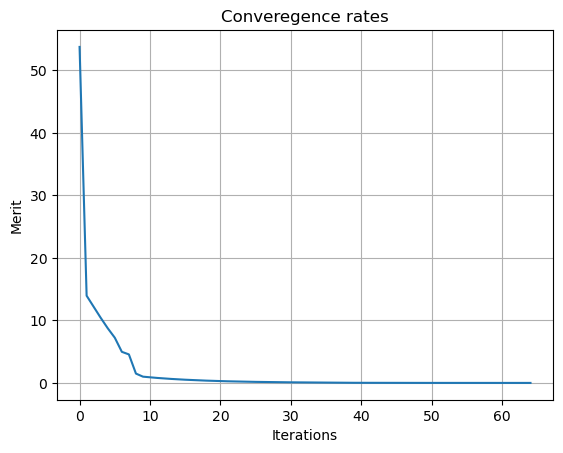

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Converegence rates')
ax.set_xlabel('Iterations')
ax.set_ylabel('Merit')
plt.grid(True)

if 'residuals' in stats.keys():
    residuals = stats['residuals']
    reject = stats['reject']
    ax.plot( residuals[np.where(reject==False)])
plt.show()